# Project on Heart Disease (Group 73)

## Introduction

Heart disease is a broad term that refers to different heart conditions. Something in common is their effect on blood flow and dilation of veins to the heart. Other factors such as age, cholestrol, and blood pressure are also closely linked with heart disease.  
Our project aims to research whether these factors have a correlation with heart disease and will provide a classification model which will predict whether a person has heart disease based on four factors:
1. Age [age]
2. Resting blood pressure (in mm Hg on admission to the hospital) [trestbps]
3. Cholesterol [chol]
4. Maximum heart rate achieved [thalach]

We will use data taken from the UCI Machine Learning Repository's Heart Disease Dataset to train our model to predict whether someone has heart disease based on the 4 risk factors listed above. Our model will use diagnoses of heart disease based on the percentage of narrowing in major arteries (with <50% narrowing meaning they don't have heart disease and >50% narrowing meaning that they do have heart disease). 

In our directory (retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease), there are four databases containing data from: Cleveland, Hungary, Long Beach (California), and Switzerland. We decided to choose the Hungarian data due to it having a binary column indicating whether or not a person is likely to have heart disease. This dataset was collected from the Hungarian Institute of Cardiology in Budapest.

######## CAN THIS CELL BE DELETED?? #############

Cleveland Clinic Foundation (cleveland.data)
Hungarian Institute of Cardiology, Budapest (hungarian.data)
V.A. Medical Center, Long Beach, CA (long-beach-va.data)
University Hospital, Zurich, Switzerland (switzerland.data)


This project aims to build a classification model to predict whether a patient presenting to the hospital would have a risk of heart disease by taking into account results from multiple medical tests. 
The dataset (https://archive.ics.uci.edu/ml/datasets/Heart+Disease) provides us with multiple attributes such as age and sex as well as a categorical attribute of whether a patient is in a risk of having a heart attack

The term “heart disease” refers to several types of heart conditions. The most common type of heart disease in the United States is coronary artery disease (CAD), which affects the blood flow to the heart. Decreased blood flow can cause a heart attack.

## Data Preparation

First, attach the libraries and load in the Hungarian dataset.

In [56]:
# Attatch the librarys
library(tidyverse)
library(tidymodels)
library(cowplot)

Load the hungarian heart disease dataset and set proper column names.

In [2]:
# load hungarian heart disease dataset from database

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

hungarian_data <- read_csv(url, col_names = c('age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol', 
                                              'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                                              'st_depression', 'peak_st_slope', 'major_vessel_num', 'thal', 'diagnosis'))
head(hungarian_data)

Rows: 294 Columns: 14
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,peak_st_slope,major_vessel_num,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Clean the dataset and keep only the columns we need for our model.

In [23]:
hungarian_clean <- hungarian_data |>
    # Select applicable columns to use as predictors.
    select(age, resting_blood_pressure, cholesterol, max_heart_rate, diagnosis) |>
    # Change the diagnosis column to factor so that it can be used as the predicted result.
    mutate(diagnosis = as.factor(diagnosis))

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("resting_blood_pressure", "cholesterol", "max_heart_rate")
hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
            filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"


Rows: 270
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,~
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 15~
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 21~
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 16~
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~


Split the cleaned data into training set and testing set, where 75% of the data are used to training while the remaining 25% will be used for testing. The proportion are chosen so that there is sufficient data to train the model with sufficient data to test the model and obtain the accuracy of the model. 

In [36]:
# Split data into training set and testing set.
set.seed(1000)

hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

Create an exploratory data analysis table using the training dataset

In [35]:
hungarian_training_explore <- hungarian_train |>
            group_by(diagnosis)|>
            summarize(n_row = n(),
                      percentage_of_total_data = n()*100/nrow(hungarian_train),
                      age_mean = mean(age),
                      resting_blood_pressure_mean = mean(resting_blood_pressure),
                      cholesterol_mean = mean(cholesterol),
                      max_heart_rate_mean = mean(max_heart_rate))

hungarian_training_explore

diagnosis,n_row,percentage_of_total_data,age_mean,resting_blood_pressure_mean,cholesterol_mean,max_heart_rate_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,126,62.68657,46.77778,129.7619,238.4921,144.6270
1,75,37.31343,49.36000,134.7600,274.4667,129.1867


Create a visualization of the distribution of predictor variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



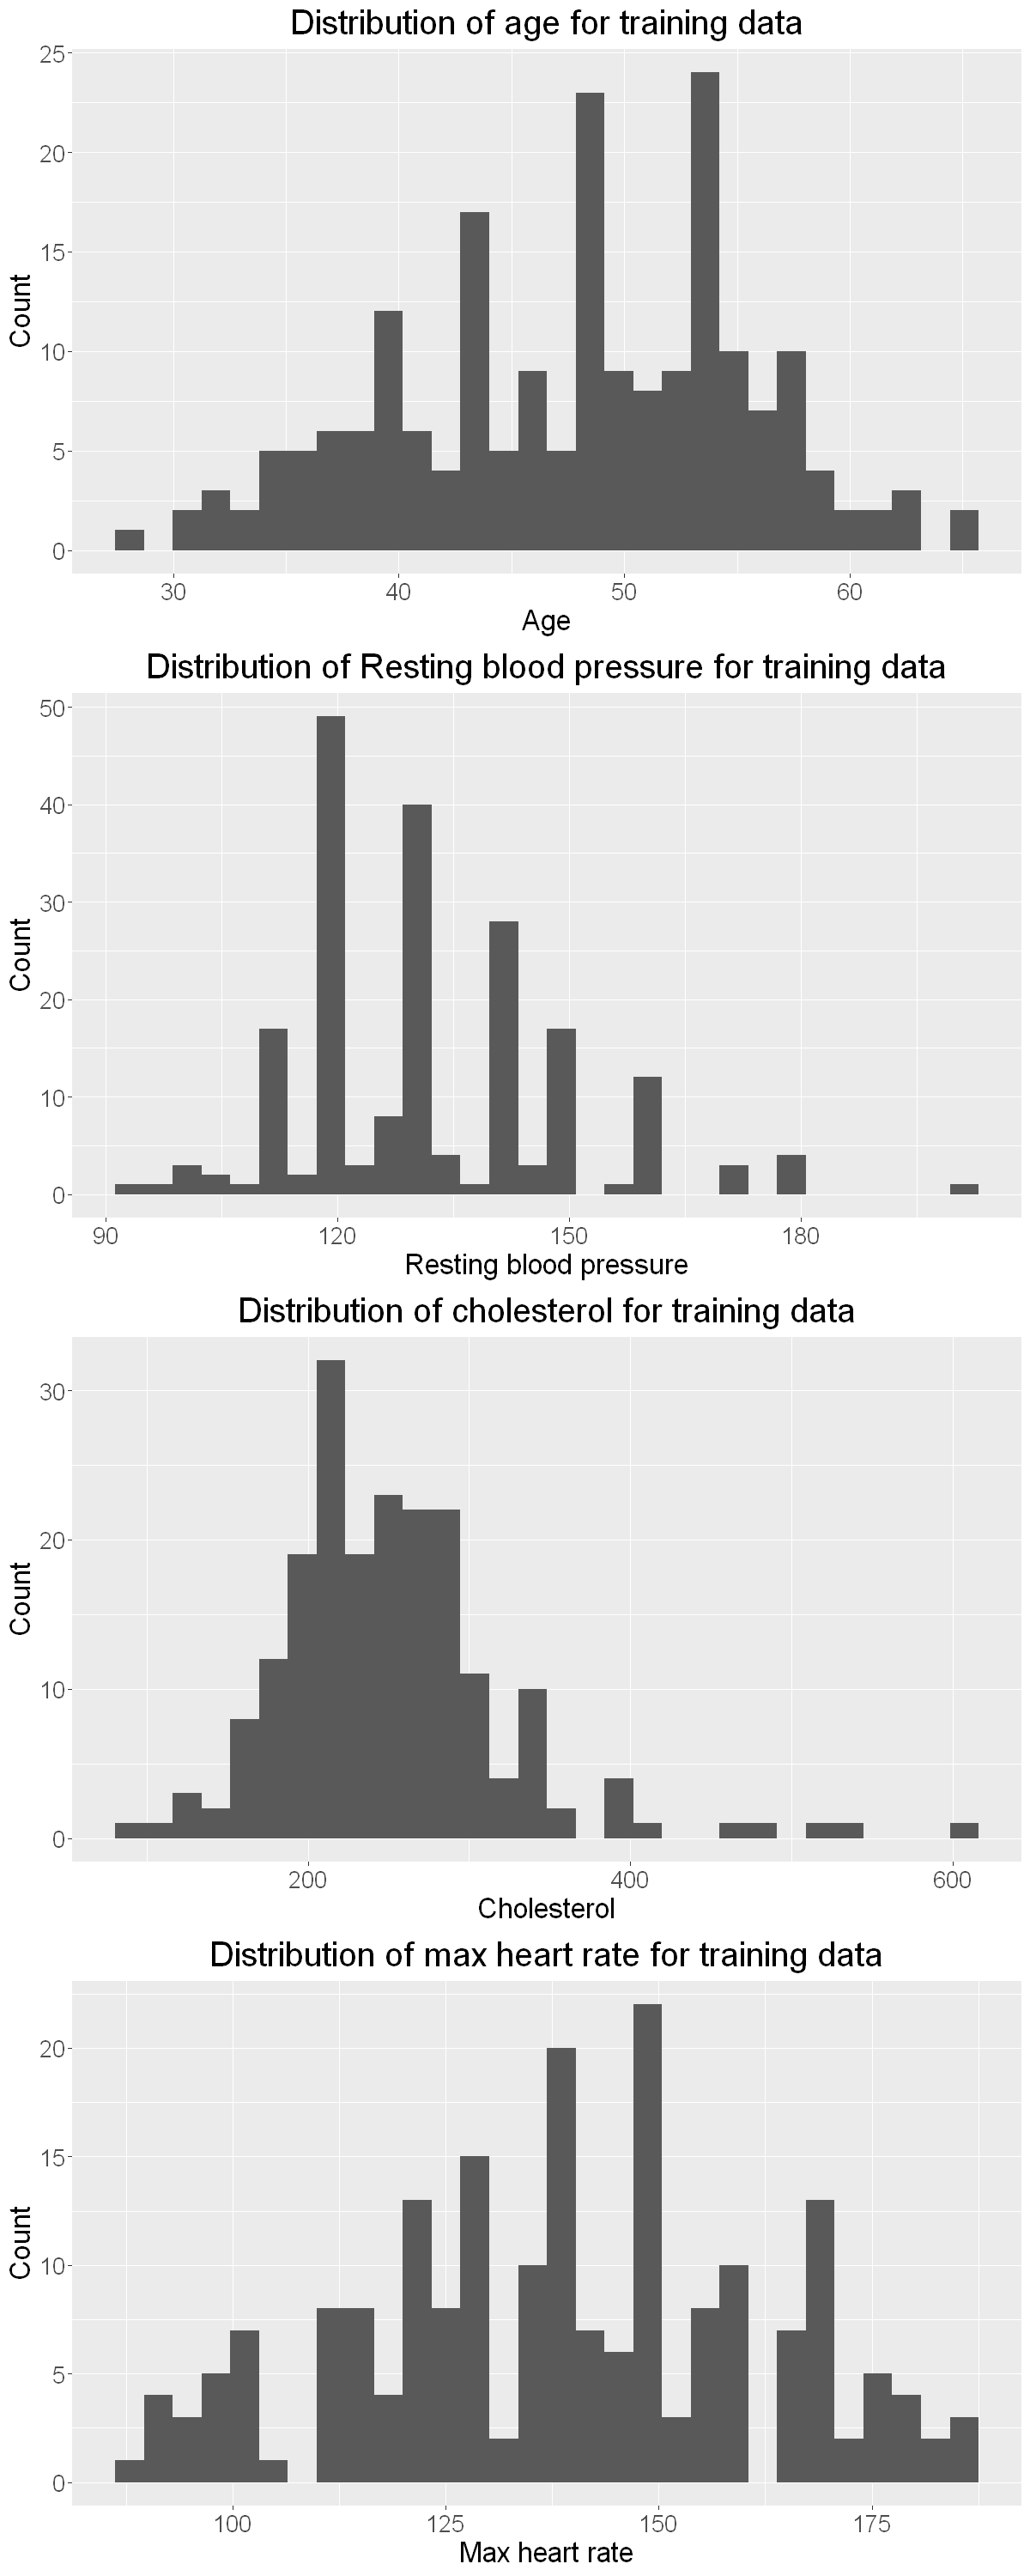

In [60]:
options(repr.plot.width = 10, repr.plot.height = 25)
plot_column <- c('age','resting_blood_pressure', 'cholesterol', 'max_heart_rate')

training_age_plot <- hungarian_train |>
                ggplot(aes(x=age))+
                geom_histogram()+
                labs(x="Age", y="Count")+
                ggtitle("Distribution of age for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_resting_blood_pressure_plot <- hungarian_train |>
                ggplot(aes(x=resting_blood_pressure))+
                geom_histogram()+
                labs(x="Resting blood pressure", y="Count")+
                ggtitle("Distribution of Resting blood pressure for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_cholesterol_plot <- hungarian_train |>
                ggplot(aes(x=cholesterol))+
                geom_histogram()+
                labs(x="Cholesterol", y="Count")+
                ggtitle("Distribution of cholesterol for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_max_heart_rate_plot <- hungarian_train |>
                ggplot(aes(x=max_heart_rate))+
                geom_histogram()+
                labs(x="Max heart rate", y="Count")+
                ggtitle("Distribution of max heart rate for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

hungarian_training_plot <- plot_grid(training_age_plot,
                                     training_resting_blood_pressure_plot, 
                                     training_cholesterol_plot, 
                                     training_max_heart_rate_plot,
                                     ncol=1)

hungarian_training_plot

## Method

We will build the classification model using k-nearest neighbors. We will build it using the training data (hungarian_train) and test it for accuracy using the testing data (hungarian_test). The number of k we use will be tuned to have the highest accuracy through cross-validation. The predictor variables we use will only be variables that have a numerical data type and not a factorable data type. This is because factorable data types can not be used for k-nearest neighbors as distance can not be calculated for factors. 

We can visualize the tuning using cross-validation by plotting a graph with number of k vs accuracy 

## Expected Outcomes and Significance

From this research project, we expect to find a correlation between risk factors (specifically, a person's age, cholesterol, maximum heart rate achieved, and resting blood pressure) and the overall likelyhood that they have heart disease. With this research, we hope to create a model that can predict (to a high level of accuracy) whether a person has heart disease. If our model is successful, it will be a great aid to the medical community by creating fast and easy diagnosis of heart disease in patients, and will allow doctors to quickly assist those in need. A doctor could simply input the measurements taken for each of the 4 risk factors and the model will determine whether the patient is developing heart disease or not. 

After our model is complete, future questions may be raised on this topic such as:
- Are there other diseases that can be accurately predicted based on a chosen set of measurable risk factors?
- Will it ever be ethical to nearly remove a doctor from the situation and trust a model instead?
- Is it possible to create a model that is 100% accurate?
- How might a model, such as ours, affect the speed at which heart disease is detected and treated, and could this lead to more lives saved in the future?

In [ ]:
####### ARE WE KEEPING ANY OF THE FOLLOWING CELLS?? ##########

In [6]:
#YAY we got our final data
#now we need to split into training and testing

#longbeach_train
#longbeach_test

long_beach_recipe <- recipe(num ~ age + trestbps + chol + thalach, data = longbeach_select) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

long_beach_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [34]:
# Now we need to make KNN spec and workflow

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
      set_engine("kknn") |>
      set_mode("classification")
#knn_spec
long_beach_fit <- workflow() |>
      add_recipe(long_beach_recipe) |>
      add_model(knn_spec) |>
      fit(data = longbeach_train)
#long_beach_fit

In [35]:
long_beach_predictions <- predict(long_beach_fit , longbeach_test) |>
      bind_cols(longbeach_test)
long_beach_predictions |>
print(n=10)

# A tibble: 69 × 6
   .pred_class   age trestbps  chol thalach num  
   <fct>       <dbl>    <dbl> <dbl>   <dbl> <fct>
 1 0              29      120   243     160 0    
 2 0              31      100   219     150 0    
 3 0              32      110   225     184 0    
 4 0              34      130   161     190 0    
 5 0              35      140   167     150 0    
 6 0              35      120   308     180 0    
 7 0              37      120   260     130 0    
 8 0              37      130   315     158 0    
 9 0              39      190   241     106 0    
10 0              40      140   289     172 0    
# … with 59 more rows


In [36]:
#Now we need to find accuracy

long_beach__prediction_accuracy <- long_beach_predictions |> #df
        metrics(truth = num, estimate = .pred_class)   #real vs estimations

long_beach__prediction_accuracy



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7101449
kap,binary,0.3320426
